In [16]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.utils.data as Data
import matplotlib.pyplot as plt

In [17]:
data = torch.load('data.pth')
data = Data.TensorDataset(data['feature'], data['label'])
train_set, test_set = random_split(data, [45000, 15000])

In [18]:
batch_size = 100
train_loader = DataLoader(train_set, batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size, shuffle=False)

feature为60000个含有256个特征的向量，label为60000个标签（10）

In [19]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 10)
        )
    
    def forward(self, x):
        return self.model(x)

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [21]:
import torch.utils.cpp_extension

torch.utils.cpp_extension.CUDA_HOME 

In [22]:
print(torch.__version__)

1.13.0


In [23]:
mlp = MLP().to(device)
lossfn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.01)

In [24]:
torch.__version__

'1.13.0'

In [25]:
print(torch.version.cuda)

None


In [26]:
epoch = 200

all_train_losses = np.zeros(epoch)
all_test_acc = np.zeros(epoch)
for i in range(epoch):
    mlp.train()
    train_losses = []
    for input, target in train_loader:
        input, target = input.to(device), target.to(device)
        optimizer.zero_grad()
        out = mlp(input)
        loss = lossfn(out, target)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    train_loss = np.mean(train_losses)
    test_acc = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)      
        outputs = mlp(inputs)
        idx = torch.argmax(outputs, dim=1)
        correct = (idx == targets).sum().item()
        n = targets.shape[0]
        test_acc.append(correct/n)
    acc = np.mean(test_acc)
    all_train_losses[i] = train_loss
    all_test_acc[i] = acc



In [27]:
torch.save(mlp.state_dict(), 'model.pth')

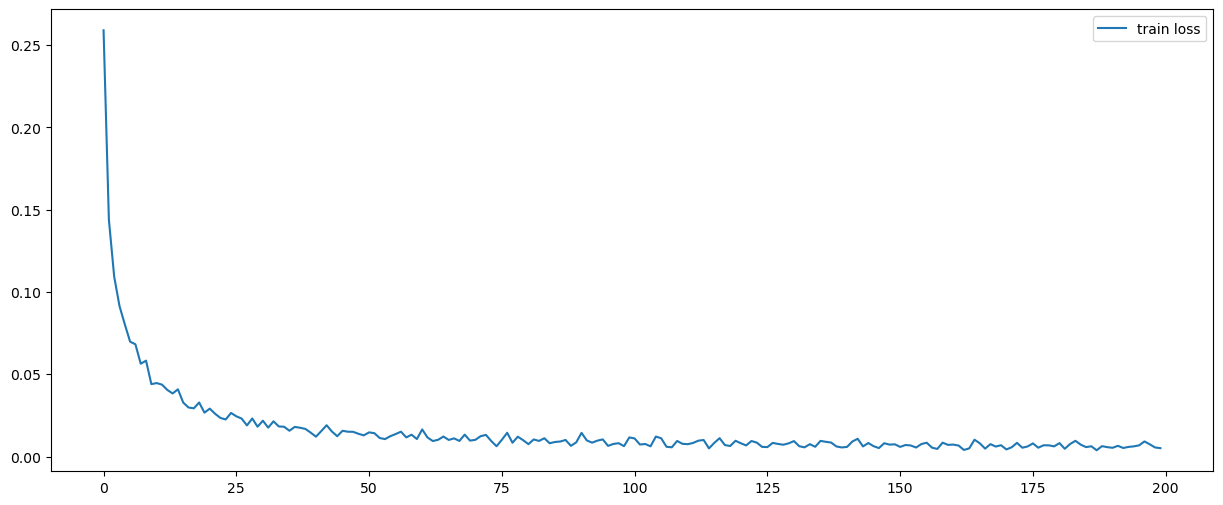

In [28]:
plt.figure(figsize=(15,6))
plt.plot(all_train_losses, label='train loss')

plt.legend()

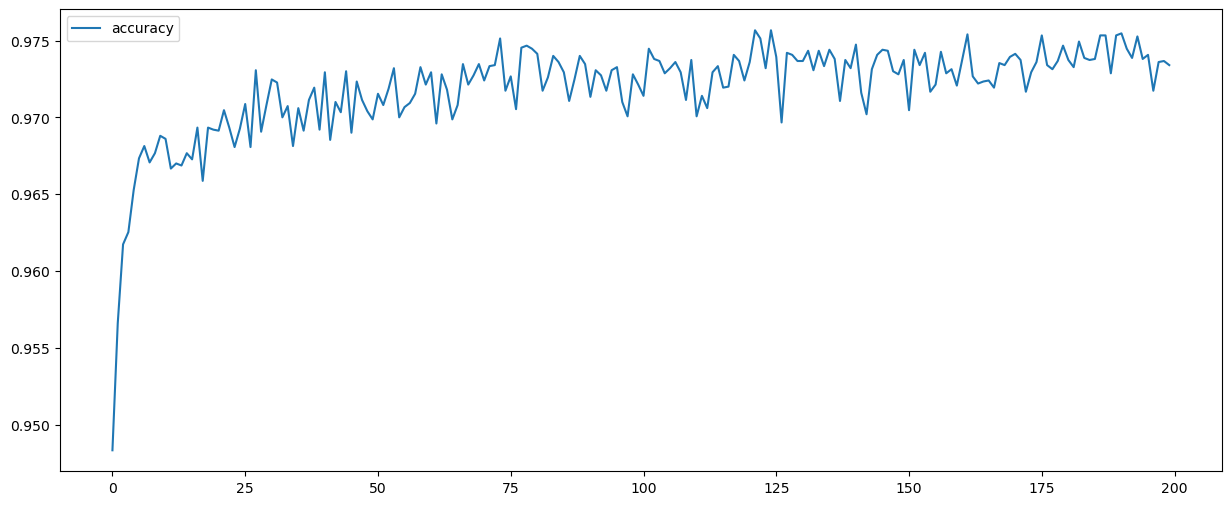

In [29]:
plt.figure(figsize=(15,6))
plt.plot(all_test_acc, label='accuracy')

plt.legend()

In [30]:
correct = 0
n = 0

for input, target in test_loader:
    input, target = input.to(device), target.to(device)
    out = mlp(input)
    idx = torch.argmax(out, dim=1)
    correct += (idx == target).sum().item()
    n += target.shape[0]

acc = correct/n
print(acc)

0.9734
